## Problem Statement
This notebook aims to reconstruct a full MRI image from undersampled k-space data using a sparse representation in a Gaussian kernel basis. The primary goal is to minimize the difference between the observed undersampled k-space and the k-space of the reconstructed image, effectively recovering the image information lost due to undersampling.

Dicom is the standard file format for medical images and stores pixel data and some other data like scanner settings patient info, slice position etc


tcia_utils nbia is the interface to the cancer imaging archive so theres available datasets we can use

In [8]:
!pip install tcia_utils pydicom torch matplotlib numpy
import torch
import numpy as np
import pydicom
import matplotlib.pyplot as plt
import os
from tcia_utils import nbia

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 81.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 93.8 MB/s eta 0:00:00


In [9]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## Data Requirements
*   **Input Data:** The model expects 2D DICOM MRI slice data. Specifically, a series of DICOM files .dcm containing pixel data and metadata
*   **Preprocessing:** Data is normalized to a [0, 1] range after clipping outliers and resized to a fixed 256x256 resolution. This preprocessed 2D image serves as the target_image for reconstruction.

Trying to find an available mri collection and downloads a series, a full stack of 2d slices
sorts them by slice order and take the middle scan

In [10]:
data = nbia.getSeries(collection="UPENN-GBM")
if data is None:
    raise RuntimeError("UPENN-GBM returned no data.")
print(f"'UPENN-GBM' returned {len(data)} series")

nbia.downloadSeries(data, number=1, path="./brain_mri")

# get middle slice
dcm_files = []
for root, dirs, files in os.walk("./brain_mri"):
    for f in files:
        if f.lower().endswith(".dcm"):
            dcm_files.append(os.path.join(root, f))

datasets = [pydicom.dcmread(f) for f in dcm_files]
datasets.sort(key=lambda ds: ds.InstanceNumber)

mid = len(datasets) // 2
ds = datasets[mid]
pixel_data = ds.pixel_array.astype(np.float32)

if hasattr(ds, 'RescaleSlope'):
    pixel_data = pixel_data * float(ds.RescaleSlope) + float(ds.RescaleIntercept)

print(f"Loaded slice {mid+1}/{len(datasets)}, shape: {pixel_data.shape}")

'UPENN-GBM' returned 3680 series
Loaded slice 61/120, shape: (256, 256)


Normalize and resize  so that gradient descent works faster:

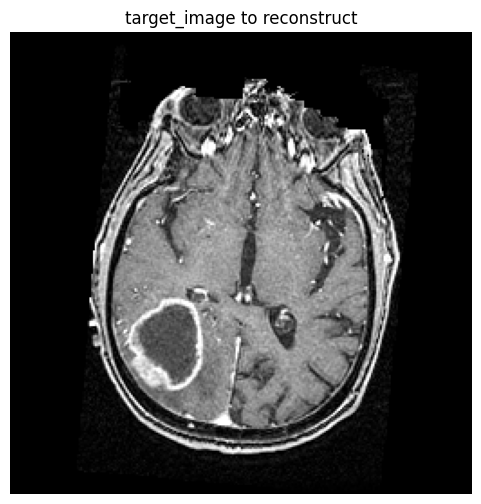

In [11]:

# Normalize to [0, 1]
# Clip  1st and 99 percentile
p_low, p_high = np.percentile(pixel_data, (1, 99))
pixel_data = np.clip(pixel_data, p_low, p_high)
pixel_data = (pixel_data - p_low) / (p_high - p_low)

# Resize to 256x256 using torch interpolate
target_image = torch.tensor(pixel_data).unsqueeze(0).unsqueeze(0)  # -> [1, 1, H, W]
target_image = torch.nn.functional.interpolate(target_image, size=(256, 256), mode='bilinear')
target_image = target_image.squeeze()  # -> [256, 256]

plt.figure(figsize=(6, 6))
plt.imshow(target_image.numpy(), cmap='gray')
plt.title("target_image to reconstruct")
plt.axis('off')
plt.show()

In [12]:
def create_kernel_basis(grid_size=256, num_kernels=16384, sigma=2.5):
    x = torch.linspace(0, grid_size, grid_size)
    y = torch.linspace(0, grid_size, grid_size)
    grid_x, grid_y = torch.meshgrid(x, y, indexing='ij')

    centers_x = torch.randint(0, grid_size, (num_kernels,))
    centers_y = torch.randint(0, grid_size, (num_kernels,))

    basis = []
    for i in range(num_kernels):
        dist_sq = (grid_x - centers_x[i])**2 + (grid_y - centers_y[i])**2
        kernel = torch.exp(-dist_sq / (2 * sigma**2))
        basis.append(kernel.flatten())

    return torch.stack(basis).T  # [65536 x num_kernels]

Phi = create_kernel_basis()
print(f"Phi shape: {Phi.shape}")

Phi shape: torch.Size([65536, 16384])


In [13]:
target_image = target_image.to(device)
# Use fftshift to move the low frequencies to the center before masking
k_full = torch.fft.fftshift(torch.fft.fft2(target_image))

mask = torch.zeros_like(k_full, dtype=torch.complex64)
center_h, center_w = k_full.shape[-2] // 2, k_full.shape[-1] // 2
dist = 128
mask[center_h - dist : center_h + dist, center_w - dist : center_w + dist] = 1

y_obs = k_full * mask

print(f"k_full shape: {k_full.shape}")
print(f"mask shape: {mask.shape}")
print(f"y_obs shape: {y_obs.shape}")

def ifft2(k_space_data):
    """Applies 2D inverse Fast Fourier Transform and returns the real part."""
    return torch.fft.ifft2(k_space_data).real

print("ifft2 function defined.")

k_full shape: torch.Size([256, 256])
mask shape: torch.Size([256, 256])
y_obs shape: torch.Size([256, 256])
ifft2 function defined.


In [14]:
num_kernels = Phi.shape[1]
c = (torch.randn(num_kernels, device=device) * 0.01).detach().requires_grad_(True)
learning_rate = .01
optimizer = torch.optim.Adam([c], lr=learning_rate)

print(f"Initialized coefficients 'c' with shape: {c.shape}")
print("Optimizer (Adam) initialized.")

Initialized coefficients 'c' with shape: torch.Size([16384])
Optimizer (Adam) initialized.


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Move everything first
Phi = Phi.to(device).float()
target_image = target_image.to(device)
mask = mask.to(device)

# Recompute k-space on device
k_full = torch.fft.fftshift(torch.fft.fft2(target_image))
y_obs = k_full * mask

# Initialize c ON DEVICE
num_kernels = Phi.shape[1]
c = (torch.randn(num_kernels, device=device) * 0.01).requires_grad_(True)

# Create optimizer AFTER moving c
optimizer = torch.optim.Adam([c], lr=0.01)

Using device: cuda


In [16]:
loss_history = []
num_epocs = 10000
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=2500, gamma=0.92
)
for epoch in range(num_epocs):
    optimizer.zero_grad()

    #Generate image from basis functions
    x_recon = (Phi @ c).reshape(256, 256)

   #ransform reconstruction to k-space
    k_recon = torch.fft.fftshift(torch.fft.fft2(x_recon))

   #apply the same mask to the reconstruction
    y_recon = k_recon * mask

    loss = torch.mean(torch.abs(y_recon - y_obs)**2)
    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch + 1}/{num_epocs}, Loss: {loss.item():.4f}")
    loss.backward()
    optimizer.step()
    scheduler.step()
    loss_history.append(loss.item())

Epoch 100/10000, Loss: 628.6689
Epoch 200/10000, Loss: 574.5040
Epoch 300/10000, Loss: 545.9191
Epoch 400/10000, Loss: 526.7639
Epoch 500/10000, Loss: 512.5939
Epoch 600/10000, Loss: 501.3908
Epoch 700/10000, Loss: 492.3605
Epoch 800/10000, Loss: 484.4284
Epoch 900/10000, Loss: 477.8012
Epoch 1000/10000, Loss: 471.9430
Epoch 1100/10000, Loss: 466.5217
Epoch 1200/10000, Loss: 461.3844
Epoch 1300/10000, Loss: 456.9967
Epoch 1400/10000, Loss: 453.2477
Epoch 1500/10000, Loss: 449.2610
Epoch 1600/10000, Loss: 445.7632
Epoch 1700/10000, Loss: 442.3910
Epoch 1800/10000, Loss: 439.3382
Epoch 1900/10000, Loss: 436.5778
Epoch 2000/10000, Loss: 433.6689
Epoch 2100/10000, Loss: 431.3811
Epoch 2200/10000, Loss: 428.9968
Epoch 2300/10000, Loss: 426.6853
Epoch 2400/10000, Loss: 424.0359
Epoch 2500/10000, Loss: 421.6350
Epoch 2600/10000, Loss: 419.5497
Epoch 2700/10000, Loss: 417.9238
Epoch 2800/10000, Loss: 415.7355
Epoch 2900/10000, Loss: 413.9430
Epoch 3000/10000, Loss: 412.3136
Epoch 3100/10000, L

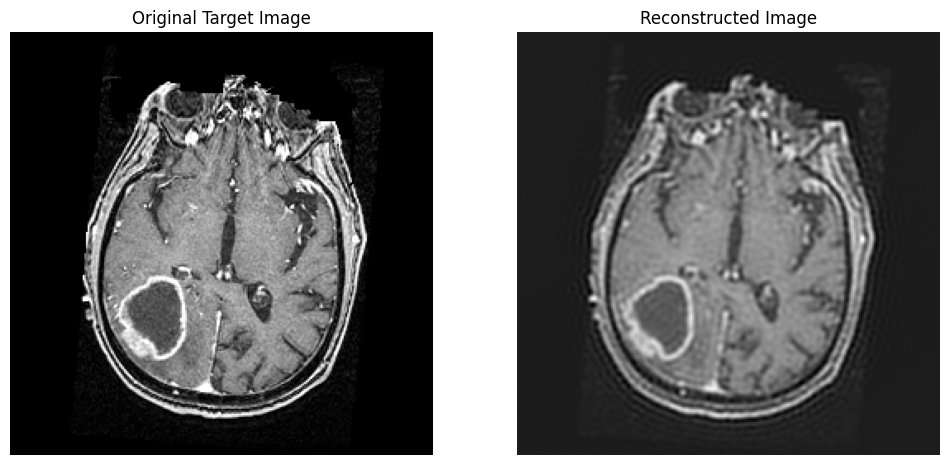

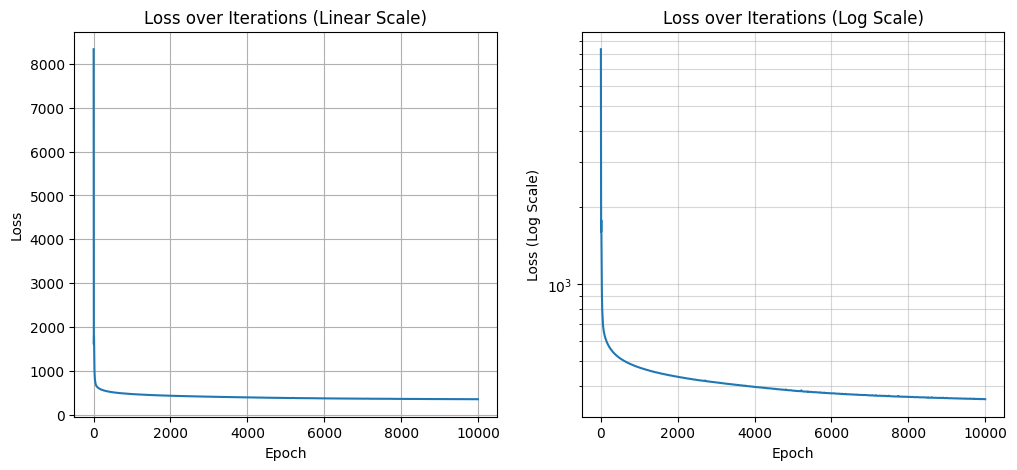

In [17]:
import matplotlib.pyplot as plt

final_x_recon = (Phi @ c).reshape(256, 256)
reconstructed_image = final_x_recon.cpu().detach().numpy()
target_image_np = target_image.cpu().detach().numpy()

#Visual Comparison: Original vs. Reconstructed
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(target_image_np, cmap='gray')
plt.title('Original Target Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image, cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')

plt.show()

#Optimization Performance: Linear and Log Loss Plots
plt.figure(figsize=(12, 5))

# Standard Linear Plot
plt.subplot(1, 2, 1)
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Iterations (Linear Scale)')
plt.grid(True)

# Log Scale Plot
plt.subplot(1, 2, 2)
plt.semilogy(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss (Log Scale)')
plt.title('Loss over Iterations (Log Scale)')
plt.grid(True, which="both", ls="-", alpha=0.5)

plt.show()

## Success Metrics
The performance of the image reconstruction is evaluated using:
*   **Mean Squared Error (MSE):** Measures the average squared difference between the reconstructed image and the original target image.
*   **Peak Signal-to-Noise Ratio (PSNR):** A common metric for image quality, providing a quantitative measure of reconstruction fidelity. Higher PSNR values indicate better reconstruction quality.

In [18]:
import torch.nn.functional as F

mse = F.mse_loss(final_x_recon.flatten(), target_image.flatten())
psnr = 10 * torch.log10(1.0 / mse)
print(f"MSE: {mse.item():.6f}")
print(f"PSNR: {psnr.item():.2f} dB")

MSE: 0.005407
PSNR: 22.67 dB


## Resource Monitoring


*   System Ram - 7.8/12.7 GB
*   GPU Ram - 4.2/15.0 GB

*   Disk - 38.8/112.6 GB





## Known Limitations
*   **Basis Function Choice:** The current implementation uses fixed-size Gaussian kernels. The choice of sigma and num_kernels is empirical and may not be optimal for all image types or reconstruction tasks.
*   **Undersampling Pattern:** The mask for k-space undersampling is a simple central region. More advanced undersampling patterns are not explored.
*   **Computational Cost:** For very large images or a significantly higher number of basis functions, the matrix multiplication Phi @ c can become computationally intensive.
*   **Lack of Regularization:** The current objective function only minimizes the k-space error. Incorporating regularization  could improve reconstruction quality and noise suppression.

## Next Steps
*   **Explore different basis functions:** Investigate other sparse representations beyond Gaussian kernels.
*   **Implement image-domain regularization:** Add Total Variation (TV) or other regularization terms to the loss function to improve reconstruction quality and noise robustness.
*   **Dynamic mask generation:** Implement methods to generate more complex or adaptive k-space undersampling masks.
*   **Hyperparameter tuning:** Systematically tune parameters like sigma, num_kernels, learning_rate, and regularization weights.
*   **Quantitative evaluation:** Perform reconstructions on a larger dataset and compare results with other MRI reconstruction methods.